In [30]:
from zod import ZodFrames
from zod.visualization.oxts_on_image import visualize_oxts_on_image
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject
from edge_code.data_loader import ZodDataset

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch import Generator
from common.groundtruth_utils import get_ground_truth
from common.static_params import *
from common.groundtruth_utils import load_ground_truth
from torch.utils.data import Dataset, RandomSampler
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [41]:
seed = 42
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE),antialias=True)])
zod_frames = ZodFrames(dataset_root="/mnt/ZOD", version="full")



Loading infos: 0it [00:00, ?it/s]

In [42]:
zod_frames[9158].oxts

EgoMotion(poses=array([[[ 1.00000000e+00,  7.00999314e-18,  1.01025249e-18,
          2.91038305e-11],
        [ 7.00999314e-18,  1.00000000e+00,  4.35679692e-17,
          8.73114914e-11],
        [ 1.01025249e-18,  4.35679692e-17,  1.00000000e+00,
          1.86264515e-09],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 9.99999883e-01, -8.66362488e-05, -4.76117368e-04,
          8.30412078e-02],
        [ 8.67598260e-05,  9.99999963e-01,  2.59537490e-04,
         -1.18143330e-03],
        [ 4.76094865e-04, -2.59578768e-04,  9.99999853e-01,
         -8.06309283e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 9.99999549e-01, -1.17590022e-04, -9.42299184e-04,
          1.66084234e-01],
        [ 1.18053291e-04,  9.99999872e-01,  4.91595920e-04,
         -2.35625735e-03],
        [ 9.42241257e-04, -4.91706940e-04,  9.99999435e-01,
         -1.56322774e-03],
        [ 0.00000000e+0

In [43]:
zod_frames[9158].ego_motion.timestamps

array([1.60595189e+09, 1.60595189e+09, 1.60595189e+09, 1.60595189e+09,
       1.60595189e+09, 1.60595189e+09, 1.60595189e+09, 1.60595190e+09,
       1.60595190e+09, 1.60595190e+09, 1.60595190e+09, 1.60595190e+09,
       1.60595190e+09, 1.60595190e+09, 1.60595190e+09, 1.60595190e+09,
       1.60595190e+09, 1.60595190e+09, 1.60595190e+09, 1.60595190e+09,
       1.60595190e+09, 1.60595190e+09])

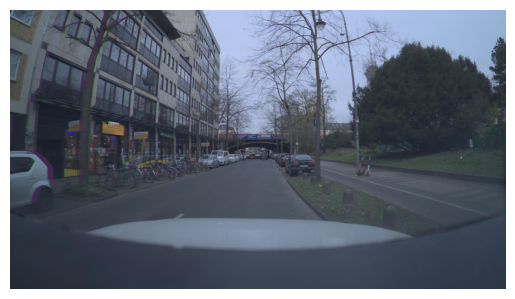

In [44]:
camera_core_frame = zod_frames[9158].info.get_key_camera_frame(Anonymization.DNAT)

# one can read the image from the filepath
image = camera_core_frame.read()
# or use a helper directly from the frame
image = zod_frames[9158].get_image(Anonymization.DNAT)

plt.axis("off")
plt.imshow(image)
plt.show()


Number of points: 3116
Number of points in fov: 3091


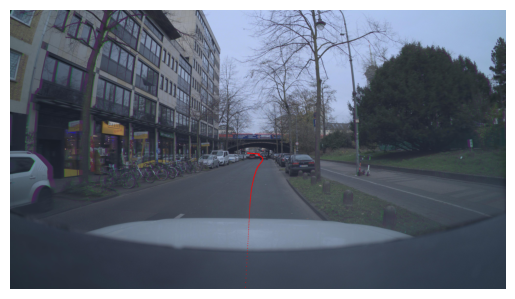

In [45]:
zod_frame = zod_frames[9158]

# extract the oxts data
oxts = zod_frame.oxts

# visualize the oxts data on the image
calibrations = zod_frame.calibration

# get the time of the keyframe (into which we want to project the oxts points)
key_timestamp = zod_frame.info.keyframe_time.timestamp()

image = zod_frame.get_image(Anonymization.DNAT)
image = visualize_oxts_on_image(oxts, key_timestamp, calibrations, image, camera=Camera.FRONT)

plt.axis("off")
plt.imshow(image)
plt.show()

In [46]:

partition = np.load("tmp/partitions.npz")["0"]

trainset = ZodDataset(zod_frames=zod_frames, frames_id_set=partition,
                        stored_ground_truth=load_ground_truth(STORED_GROUND_TRUTH_PATH), transform=transform)
testset = ZodDataset(zod_frames=zod_frames, frames_id_set=partition,
                        stored_ground_truth=load_ground_truth(STORED_GROUND_TRUTH_PATH), transform=transform)

# Split each partition into train/val and create DataLoader
len_val = int(len(trainset) * VAL_FACTOR)
len_train = int(len(trainset) - len_val)

lengths = [len_train, len_val]
ds_train, ds_val = random_split(trainset, lengths, Generator().manual_seed(seed))
train_sampler = RandomSampler(ds_train)

trainloader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, sampler=train_sampler)
valloader = DataLoader(ds_val, batch_size=BATCH_SIZE, num_workers=4)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, num_workers=4)

In [49]:
# BATCH_SIZE = 8
# IMG_SIZE = 224
# NUM_OUTPUT = 51

for (images, labels) in testloader:
    print(images.size())
    print(labels.size())
    break

torch.Size([8, 3, 224, 224])
torch.Size([8, 51])
